Import modules and prepare data set

In [1]:
import sys
genpath = 'D:/Code'
if genpath not in sys.path:
    sys.path.append(genpath)

import DataSciPy
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import validation_curve
from scipy.sparse import vstack
import pickle
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import src.general_helper as genH

Load the data set and split the `fingerprint`-column to one column for each character.

In [2]:
final_db = pd.read_csv('data/processed/final_db_update.csv')
fp = pd.DataFrame(final_db.fingerprint.apply(DataSciPy.splt_str))
fp = pd.DataFrame(fp.fingerprint.tolist(), index=fp.index)
final_db_manyfeat = final_db.drop(columns=['fingerprint']).join(fp).drop(columns=['test_cas'])
final_db = final_db.drop(columns=['fingerprint','Mol','atom_number','alone_atom_number','bonds_number']).join(fp).drop(columns=['test_cas'])
# Prepare binary classification problem and encode features
final_db = genH.binary_score(final_db)
final_db_manyfeat = genH.binary_score(final_db_manyfeat)

There are 8566 datapoints with label 0 and 14761 datapoints with label 1
There are 8566 datapoints with label 0 and 14761 datapoints with label 1


In [6]:
print(final_db_manyfeat.columns[0:20])

Index([          'species',        'conc1_type',     'exposure_type',
       'obs_duration_mean',       'atom_number', 'alone_atom_number',
            'bonds_number',        'doubleBond',        'tripleBond',
             'ring_number',               'Mol',     'MorganDensity',
                    'LogP',             'class',         'tax_order',
                  'family',             'genus',                   0,
                         1,                   2],
      dtype='object')


Prepare the dataset object

In [7]:
dummy = DataSciPy.Dataset()
dummy.setup_data(X=final_db_manyfeat.drop(columns=['score']),
                 y=final_db_manyfeat.loc[:,['score']],
                 split_test=0.3)
encode_these = ['ring_number','doubleBond','tripleBond','alone_atom_number','species',
                'conc1_type','exposure_type','obs_duration_mean','family','genus','tax_order','class']
dummy.encode_categories(variables=encode_these, onehot=True)

In [8]:
print(dummy.X_train.shape)

(16328, 1838)


# Fit perceptrons to the ecotoxicological data

In [9]:
acc_test = np.zeros((100,))
acc_train = np.zeros((len(acc_test,)))
for i in range(len(acc_test)):
    per = Perceptron(tol=1e-3, random_state=i)
    per.fit(dummy.X_train, dummy.y_train.iloc[:,0])
    acc_test[i] = per.score(dummy.X_test, dummy.y_test.iloc[:,0])
    acc_train[i] = per.score(dummy.X_train, dummy.y_train.iloc[:,0])

Plot histogram of accuracies.

0.8296899557079582
0.8358035276825085


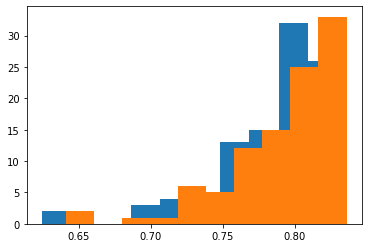

In [13]:
plt.hist(acc_test)
plt.hist(acc_train)
print(np.max(acc_test))
print(np.max(acc_train))

Drop all the columns of the fingerprint and repeat the procedure above. Like this we can assess the value added by the fingerprint data.

In [13]:
acc_nofinger_test = np.zeros((100,))
acc_nofinger_train = np.zeros((len(acc_nofinger_test),))
for i in range(len(acc_nofinger_test)):
    per = Perceptron(tol=1e-3, random_state=i)
    per.fit(dummy_nofinger.X_train, dummy_nofinger.y_train.iloc[:,0])
    acc_nofinger_test[i] = per.score(dummy_nofinger.X_test, dummy_nofinger.y_test.iloc[:,0])
    acc_nofinger_train[i] = per.score(dummy_nofinger.X_train, dummy_nofinger.y_train.iloc[:,0])

Plot histogram of accuracies reached without fingerprint information

(array([ 3.,  3.,  1.,  5.,  5.,  6., 12., 17., 18., 30.]),
 array([0.4127266 , 0.43748775, 0.4622489 , 0.48701004, 0.51177119,
        0.53653234, 0.56129348, 0.58605463, 0.61081578, 0.63557692,
        0.66033807]),
 <a list of 10 Patch objects>)

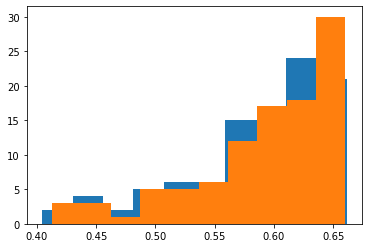

In [14]:
plt.hist(acc_nofinger_test)
plt.hist(acc_nofinger_train)

In [20]:
dummy.X_train.shape

(16328, 2477)

When comparing the two plots above, we can see that the fingerprint information manages to raise the upper mode of the (bimodal) accuracy distribution from 0.65 to 0.85. And the lower mode by a similar amount.

# Fit a multilayer perceptron (NN) to the data

In [21]:
clf = MLPClassifier(solver='adam', alpha=1e-5, max_iter=500, hidden_layer_sizes=(256,128,16))
param_range = np.logspace(-8,1,4)
trn_scores, vld_scores = validation_curve(clf,
                                          vstack([dummy.X_train, dummy.X_test]), #vstack is the sparse matrix method equivalent to append
                                          dummy.y_train.append(dummy.y_test).iloc[:,0],
                                         param_name='alpha',
                                         param_range=param_range)

C:\Users\Lori\.conda\envs\pyt36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
C:\Users\Lori\.conda\envs\pyt36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
C:\Users\Lori\.conda\envs\pyt36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
C:\Users\Lori\.conda\envs\pyt36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
C:\Users\Lori\.conda\envs\pyt36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Plot the validation curve calculated above (code copied from this[https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html#sphx-glr-auto-examples-model-selection-plot-validation-curve-py] page).

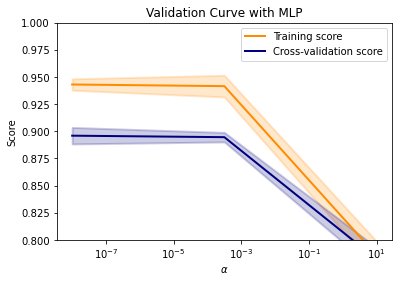

In [17]:
train_scores_mean = np.mean(trn_scores, axis=1)
train_scores_std = np.std(trn_scores, axis=1)
test_scores_mean = np.mean(vld_scores, axis=1)
test_scores_std = np.std(vld_scores, axis=1)

plt.title("Validation Curve with MLP")
plt.xlabel(r"$\alpha$")
plt.ylabel("Score")
plt.ylim(0.8, 1.0)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [ ]:
acc_test = np.zeros((10,))
acc_train = np.zeros((len(acc_test,)))
# maybe use talos for this
for i in range(len(acc_test)):
    clf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(10, 3), random_state=i, verbose=True)
    clf.fit(dummy.X_train, dummy.y_train.iloc[:,0])
    pred_test = clf.predict(dummy.X_test)
    pred_train = clf.predict(dummy.X_train)
    acc_test[i] = (pred_test==dummy.y_test.iloc[:,0]).sum()/len(pred_test)
    acc_train[i] = (pred_train==dummy.y_train.iloc[:,0]).sum()/len(pred_train)

Plot histogram of multilayer perceptron

In [ ]:
plt.hist(acc_test)
plt.hist(acc_train)
clf.estimator.loss_curve_

## Fit NN implemented in Keras / Tensorflow

In [14]:
import tensorflow as tf
import os
from tensorflow import keras
from sklearn.model_selection import KFold, StratifiedKFold

In [15]:
model0 = keras.models.Sequential()
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=1, seed=1)
model0.add(keras.Input(shape=(dummy.X_train.shape[1],)))
model0.add(keras.layers.Dense(20, activation='relu', kernel_initializer=initializer))
model0.add(keras.layers.Dropout(rate=0.2))
model0.add(keras.layers.Dense(20, activation='relu', kernel_initializer=initializer))
model0.add(keras.layers.Dropout(rate=0.2))
model0.add(keras.layers.Dense(1, activation='sigmoid', kernel_initializer=initializer))
model0.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # 'cross-entropy' is the same as the 'log-loss' of scikitlearn
model0.save_weights('output/nn/manyfeat/model0/model0_initial_weights.h5') # save the initialized weights for n-fold cross validation

model1 = keras.models.Sequential()
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=1, seed=1)
model1.add(keras.Input(shape=(dummy.X_train.shape[1],)))
model1.add(keras.layers.Dense(20, activation='relu', kernel_initializer=initializer))
model1.add(keras.layers.Dropout(rate=0.2))
model1.add(keras.layers.Dense(20, activation='relu', kernel_initializer=initializer))
model1.add(keras.layers.Dropout(rate=0.2))
model1.add(keras.layers.Dense(20, activation='relu', kernel_initializer=initializer))
model1.add(keras.layers.Dropout(rate=0.2))
model1.add(keras.layers.Dense(20, activation='relu', kernel_initializer=initializer))
model1.add(keras.layers.Dropout(rate=0.2))
model1.add(keras.layers.Dense(20, activation='relu', kernel_initializer=initializer))
model1.add(keras.layers.Dropout(rate=0.2))
model1.add(keras.layers.Dense(1, activation='sigmoid', kernel_initializer=initializer))
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # 'cross-entropy' is the same as the 'log-loss' of scikitlearn
model1.save_weights('output/nn/manyfeat/model1/model1_initial_weights.h5') # save the initialized weights for n-fold cross validation

model2 = keras.models.Sequential()
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=1, seed=1)
model2.add(keras.Input(shape=(dummy.X_train.shape[1],)))
model2.add(keras.layers.Dense(200, activation='relu', kernel_initializer=initializer))
model2.add(keras.layers.Dropout(rate=0.2))
model2.add(keras.layers.Dense(50, activation='relu', kernel_initializer=initializer))
model2.add(keras.layers.Dropout(rate=0.2))
model2.add(keras.layers.Dense(1, activation='sigmoid', kernel_initializer=initializer))
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # 'cross-entropy' is the same as the 'log-loss' of scikitlearn
model2.save_weights('output/nn/manyfeat/model2/model2_initial_weights.h5') # save the initialized weights for n-fold cross validation


mdls = [model2]

clbck = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", restore_best_weights=True, patience=100
)

kfold = StratifiedKFold(n_splits=5, shuffle=True)
w = dummy.y_train.iloc[:,0].value_counts()
class_weight = {0: len(dummy.y_train)/w[0]/2, 1: len(dummy.y_train)/w[1]/2}
rand_init = 3 # number of random weight inizializations

In [16]:
# Tensorflow does not accept boolean (or int) data, so convert to float
X_trn = dummy.X_train.astype(np.float32)
X_tst = dummy.X_test.astype(np.float32)
y_trn = dummy.y_train.astype(np.float32)
y_tst = dummy.y_test.astype(np.float32)
# Fit all models
for i in range(len(mdls)):
    os.makedirs('output/nn/manyfeat/model'+str(i), exist_ok=True)
    cv = 0
    model = mdls[i]
    for trn_ind, vld_ind in kfold.split(X_trn, y_trn):
        for ini in range(rand_init):
            model = DataSciPy.shuffle_weights(model)
            hist = model.fit(np.array(X_trn.iloc[trn_ind,:]),
                      np.array(y_trn.iloc[trn_ind,0]),
                      validation_data=(np.array(X_trn.iloc[vld_ind,:]), np.array(y_trn.iloc[vld_ind,0])),
                      batch_size=32, epochs=1000, verbose=0, class_weight=class_weight, callbacks=[clbck])
            model.save_weights('output/nn/manyfeat/model'+str(i)+'/cv'+str(cv)+'ini'+str(ini)+'.h5')
            DataSciPy.plot_history(hist, file='output/nn/manyfeat/model'+str(i)+'/cv'+str(cv)+'ini'+str(ini)+'_training_hist.pdf')
        cv = cv + 1

  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']


KeyboardInterrupt: 